# Milestone 3 - Implementing Google’s Deep Dream

__Objective__: Implement Google’s Deep Dream algorithm. This allows you to start manipulating CNNs and understanding how we begin to use Artificial Intelligence to generate art by utilizing pre-learned knowledge stored in the latent space of pretrained CNNs.

__Workflow__:

The principle of Google's Deep Dream is that we freeze the weights of a pretrained CNN and instead of training, we modify the input image. It essentially creates a  feedback loop where the input image is fed back into the CNN, the CNN runs in reverse, and the output effects are amplified on our image.

1.  Create some helper utilities such as:
    - An image loader that converts a loaded image into a `NumPy` array in the RBG format 
    - A deprocess function that undoes the processing done for the Inception model.
2. Now let's calculate the loss for each iteration of the Deep Dream algorithm.
    -  We firstly add a batch dimension to the image and then grab the activations, from specified layers of the Inception network after performing a forward pass.
    - We will store the intermediate losses in a list and while iterating over the layer activations, we compute the mean of each activation.
3. Create a function that does a single pass of the deep dream algorithm. It is to perform a forward-pass and then taking the gradients, use them to update the input image to generate the deep dream effects.
4. Create another function that runs the previous function for a user-specified number of iterations (100 is a good default value). It takes in the image input, the model (inception preferably), and a step size setting (use 0.01 as the default).
    - In this function, we'll take the input image, apply our preprocess function to it
    - Next, we will iterate using our single-pass deep dream function to update the image.
    - We will then return the deproessed image.

5. Now let's build our deep dream model
    - Load the inception model using the pretrained imagenet weights and without the top included.
    - Choose the layers you'll be using to generate your deep dream effects e.g. `mixed3`, 'mixed7`, and so on. 
    - Set the number of octaves (i.e. the image sizes we'll be using).
    - Set the octave scale which is the scaling factor by which we change the image size used for each octave.
    - Create our `deepDreamModel` by using `tf.keras.Model(inputs=baseModel.input, outputs=layers)`
    - Convert the image to a TensorFlow constant for improved performance
    - Take the first two dimensions of the image and cast them to a `float`
6. Use all our building blocks to generate Deep Dream's effects
    - Iterate over the number of octaves
    - get the new image shape for that given octave and convert it to a NumPy array
    - run it through your full deep dream model that you created in step 10 

7. Save and display your image. Experiment with different octaves, scales, layers to produce some trippy effects! Congratulations, you've just made your first AI-generated Art. Next, we'll step this up a notch by attempting Neural Style Transfer in the next milestone. 

__Purpose__:

The purpose of this lesson was to demonstrate how we can create the building blocks and implement the tecniques used or Google Dream algorithm.
You would have learned how to use TensorFlow 2.0’s Gradient Tape to log gradients.  How to take the pretrained InceptionV3 model to create the Deep Dream Model. How the Deep Dream algorithm works by freezing the weights of a pretrained CNN and instead of training, we modify the input image. This essentially creates a feedback loop where the input image is fed back into the CNN, the CNN runs in reverse, and the output effects are amplified on our image.


__Deliverable__:

The deliverable is a Jupyter Notebook documenting your workflow as you implement Google's Deep Dream algorithm and share some of your AI generated Art by changing the number of Octaves, Octave scale, and layers used.

In [ ]:
# Import the libraries we need to start putting Google's Deep Dream together
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from PIL import Image
import tensorflow as tf
import numpy as np
import imutils
import cv2

### Image Loader Function
Load the image, resize it to a width of 350. We then swap the color channels from BGR to RGB, and return the image as a NumPy array.

In [ ]:
def loadImage(imagePath):
    '''returns the image pixel array resiezd to a width of 350'''
    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=350)
    # convert from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(image)
    return image

### Deprocess Function 
Utility function to convert a tensor into a valid image. It "undoes" the preprocessing done for Inception and then casts the pixel values to integers

In [ ]:
def deprocess(image):
    '''returns the deprocessed image'''
    image = 255 * (image + 1.0) 
    image /= 2.0
    image = tf.cast(image, tf.uint8)
    return image

### Calculate the loss after a single iteration of the DeepDream algorithm

We firstly add a batch dimension to the image and then grab the activations, from specified layers of the Inception network after performing a forward pass.

In [ ]:
def calculateLoss(image, model):
    '''returns the sum of losses'''
    image = tf.expand_dims(image, axis=0)
    layerActivations = model(image)

    # Create a list to store the intermediate losses
    losses = []

    # iterate over the layer activations
    for act in layerActivations:
        # compute the mean of each activation
        loss = tf.reduce_mean(act)
        # append these losses to the losses list
        losses.append(loss)

    # return the sum of the losses
    return tf.reduce_sum(losses)

## The Deep Dream function

This function performs a forward-pass and then taking the
gradients and using them to update the input image to generate the deep dream effects.

We input our model (inception network preferablly), the input image, the step size we use for our gradient updates and EPS, a tiny value used to prevent divide by zero errors.

In [ ]:
# This is new addition to TF2.0. When we use the **tf.function** decorator to a function.
# TensorFlow will automatically compile it into a graph which leads to faster execution.
@tf.function
def deepDreamSinglePass(model, image, stepSize, eps=1e-8):
    ''' returns a tuple of the loss and the updated image'''

    # Tells TenorFlow to record gradients
    with tf.GradientTape() as tape:
        # keep track of the image to calculate gradients and loss 
        tape.watch(image)
        loss = calculateLoss(image, model)

    # calculates the gradients of the loss with respect to the image
    gradients = tape.gradient(loss, image)
    # normalize the gradients 
    gradients /= tf.math.reduce_std(gradients) + eps 
    # K.maximum(K.mean(K.abs(grads)), K.epsilon())

    # adjusts the image with the normalized gradients 
    image = image + (gradients * stepSize)
    # clip its pixel values to the range [-1, 1]
    image = tf.clip_by_value(image, -1, 1)

    return (loss, image)

### Function that runs our Deep Dream Model

Up to this point we can perform a single forward-pass of the DeepDream algorithm. We now need to design our training loop that enables us to do this for multiple iterations.

The `fullDeepDreamModel` we will be making below will allow us to pass our model (inception) and input image for a specified number of iterations.

In [ ]:
def fullDeepDreamModel(model, image, iterations=50, stepSize=0.01):
    '''runs the deep dream algorithm for a specified number of iterations 
    and returns the depresocessed image'''

    # preprocess the image for the Inception network
    image = preprocess_input(image)

    # We iterate for the specified number of iterations
    for iteration in range(iterations):
        # use  our deepDreamSinglePass function to get the loss and the updated image
        (loss, image) = deepDreamSinglePass(model, image, stepSize)

        # print updates on the iteration progress
        if iteration % 50 == 0:
            print ("Iteration {} with loss {}".format(iteration, loss))

    return deprocess(image)

#### Define the layers we are going to use for the dream


In [ ]:
# Chose the layers you'll be using 
names = ["mixed2", "mixed3","mixed4","mixed5", "mixed7"]

# define the octave scale and number of octaves (tweaking these values
# will produce different output dreams)
OCTAVE_SCALE = 1.3
NUM_OCTAVES = 6

### Execute Deep Dream



In [ ]:
# get our input image

sampleImage = loadImage('sample.jpeg')
print("Loaded Image")

# load the pre-trained Inception model from disk
print("Loading Inception Model...")
baseModel = InceptionV3(include_top=False, weights="imagenet")
print("Loaded Inception Model")

Loaded Image
Loading Inception Model...
87916544/87910968 [==============================] - 4s 0us/step
Loaded Inception Model


In [ ]:
# Explore the layers you can use by looking at the model summary
# try using different mixed layers
baseModel.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
# build our dreaming model
layers = [baseModel.get_layer(name).output for name in names]
deepDreamModel = tf.keras.Model(inputs=baseModel.input, outputs=layers)

# We convert the image to a TensorFlow constant for better performance,
image = tf.constant(sampleImage)

# We take the first two dimensions of the image and cast then them to float
baseShape = tf.cast(tf.shape(image)[:-1], tf.float32)

# Run our Deep Dream Generator!



Working on octave 0
Iteration 0 with loss 1.1442153453826904
Iteration 50 with loss 1.4027317762374878
Iteration 100 with loss 1.5619715452194214
Iteration 150 with loss 1.67228102684021
Iteration 200 with loss 1.7637879848480225
Iteration 250 with loss 1.8404277563095093
Iteration 300 with loss 1.9064984321594238
Iteration 350 with loss 1.964375376701355
Iteration 400 with loss 2.015881299972534
Iteration 450 with loss 2.0628271102905273
Iteration 500 with loss 2.107271909713745
Iteration 550 with loss 2.149636745452881
Iteration 600 with loss 2.190035820007324
Iteration 650 with loss 2.2284932136535645
Iteration 700 with loss 2.264188289642334
Iteration 750 with loss 2.2977378368377686
Iteration 800 with loss 2.3296635150909424
Iteration 850 with loss 2.3608970642089844
Iteration 900 with loss 2.391035556793213
Iteration 950 with loss 2.4207801818847656
Working on octave 1
Iteration 0 with loss 1.3950014114379883
Iteration 50 with loss 1.7263511419296265
Iteration 100 with loss 1.867

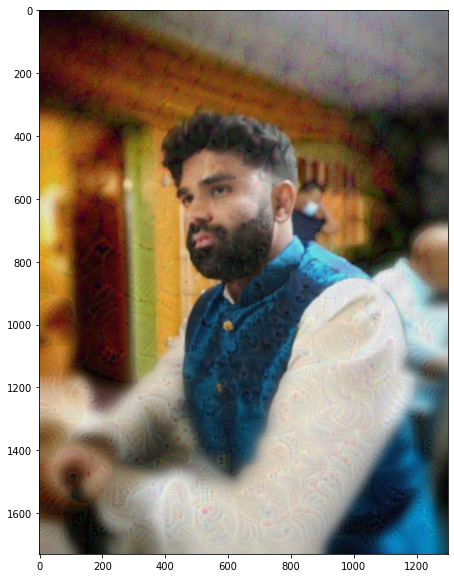

In [ ]:
import matplotlib.pyplot as plt

# We iterate over the number of Octaves (sizes) we are going to create using Deep Dream
for n in range(NUM_OCTAVES):

    # get the width and height for the current octave and cast them to integers
    print("Working on octave {}".format(n))
    newShape = tf.cast(baseShape * (OCTAVE_SCALE ** n), tf.int32)

    # Resize the image with new shape and convert it to numpy before running 
    # through our DeepDream Model
    image = tf.image.resize(image, newShape).numpy()
    image = fullDeepDreamModel(model=deepDreamModel, image=image, iterations=1000, stepSize=0.0001)

# convert the final image to a numpy array and then save it to disk
finalImage = np.array(image)
cv2.imwrite('output.jpg', finalImage)

plt.figure(figsize=(20,10)) 
plt.imshow(finalImage)

## Please experiment with diferent Octaves, Iterations, Layers and Octave Scales!

Start making your own 'Art'